## Imporing the libs

In [279]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import multivariate_normal
from IPython.display import clear_output as clr

### mAnUfacturing the Data for testing model...

In [280]:
X = np.vstack([np.random.rand(100,2),(np.random.rand(100,2)-2),(np.random.rand(100,2)+2),(np.random.rand(100,2)+np.array([-2,2]))])
X.shape

(400, 2)

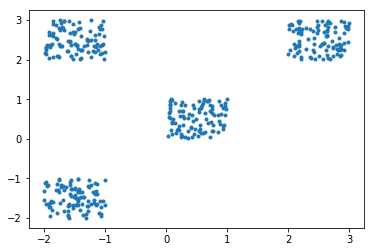

In [281]:
plt.plot(X[:,0],X[:,1],'.')

## Model

#### Model Init

In [335]:
z=[]
c=[]
N=X.shape[0]
D=X.shape[1]
K=1
alpha=0.4
z=np.zeros((N,K))

mu_ids=np.random.choice(np.arange(N), K)
mu = X[mu_ids,:]


for i in range(K):
    z[mu_ids[i],i]=1


c = np.sum(z, axis = 0).reshape(-1,1)
print(alpha*np.log(N))
print(c)

2.3965858188431928
[[1.]]


## Learning

In [336]:
var=np.identity(D)
for epoch in range(50):
    prob=[]
    
    for n in range(N):
        mu_dists=[]
        
        x_i = X[n,:] # 1 x D vector
        z_i = z[n,:] # 1 x K vector
        
        z_i_k = np.argmax(z_i)
        
        ## Book keeping lists ..
        p_xi_s = [] # probs of x_i_k will be a Kx1 length list finally...
        fracs_zis = [] # fracs values p(z_i | z_(-i)) wioll also be a Kx1 vector finally...
        
        
        for k in range(K):
            
            # Finding Z posterior ......
            mean=mu[k]
            frac1=c[k]/(alpha+N-1)
            fracs_zis.append(frac1[0])
            p_xi_k = multivariate_normal.logpdf(x_i, mean=mean, cov=var)
            p_xi_s.append(p_xi_k)
            
            
            # Finding Mu's posterior ......
            z_n = z[:,k].reshape(-1,1) # N x 1 vector
            x_sum = np.sum(X*z_n, axis = 0) # D x 1 vector
    

            deno = c[k]
            if(z_i_k == k):
                deno -= 1
                x_sum -= x_i

            mean1=x_sum/(deno + 0.001)
            var1= var/(deno + 0.001)
            q1=multivariate_normal(mean=mean1, cov=var1) ## check
            mu_dists.append(q1)
        
        
        
        # For the new cluster ....
        frac2 = alpha/(alpha+N-1)
        new_logprob=(-0.25* np.dot(x_i,x_i.T)) - D*np.log(2*(np.pi)**(1/2))
        p_xi_s.append(new_logprob)
        fracs_zis.append(frac2)
        
        
        
        # For current point the z_i ....
        logpdfs = np.array(p_xi_s)
        logpdfs = logpdfs - np.max(logpdfs)
        pdfs = np.exp(logpdfs)
        p_zi = np.array(fracs_zis)*pdfs # 1 x K+1 vector
        p_zi = p_zi/np.sum(p_zi)
        
        ### Sampling the z's and mu's
        z_i_sample = np.random.choice(np.arange(K+1), p = p_zi)
        
        
        mu_list = []
        for k in range(K):
            mu_k = mu_dists[k].rvs()
            mu_list.append(mu_k)
        
        if(z_i_sample == K):
            mu_list.append(x_i)
            tmp = np.zeros((N, 1))
            z = np.hstack([z,tmp])
            K += 1
            
        z[n,z_i_k] = 0
        z[n,z_i_sample] = 1
        
        mu = np.array(mu_list)
        c = np.sum(z, axis = 0).reshape(-1,1)
        
        idx = list(np.arange(K))
        for i in range(K):
            if(c[i] == 0):
                idx.pop(i)
                K -= 1
        
        z  = z[:,idx]
        mu = mu[idx,:]
        c = np.sum(z, axis = 0).reshape(-1,1)
        
    print("Epoch :",epoch,n,k,"Current Size :", K,"N_Cluster", c.reshape(1,-1))
    clr(wait = True)

Epoch : 49 399 3 Current Size : 4 N_Cluster [[ 98.  99.  98. 105.]]


### Visualization

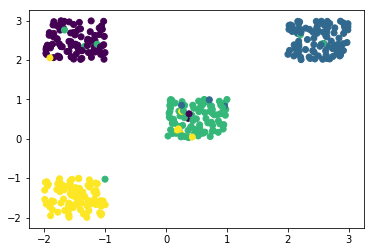

In [337]:
plt.scatter(X[:,0],X[:,1], c = np.argmax(z, axis = 1))
plt.savefig("Scatter.png")
plt.show()

In [338]:
x_grid = np.arange(-3,4,0.05)
y_grid = np.arange(-3,4,0.05)
xx, yy = np.meshgrid(x_grid, y_grid)

x_flat = xx.reshape(-1,1)
y_flat = yy.reshape(-1,1)


zz = x_flat*0

for i in range(x_flat.shape[0]):
    x_i = np.array([x_flat[i], y_flat[i]]).T
    vec = []
    for k in range(K):
        mean=mu[k]
        p_xi_k = multivariate_normal.logpdf(x_i, mean=mean, cov=var)
        vec.append(p_xi_k)
    
    zz_i = np.argmax(vec)
    zz[i] = zz_i

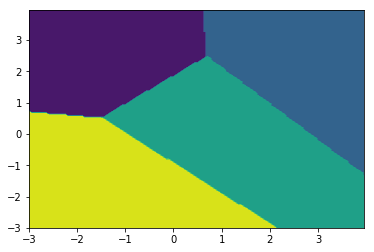

In [339]:
plt.contourf(x_grid,y_grid, zz.reshape(x_grid.shape[0],x_grid.shape[0]))
plt.savefig("Contourf.png")
plt.show()

### Thankyou for visiting .. :)